# Notebook: First data exploration and preprocessing

This notebook contains a first exploration of the data and insights that led to further modeling choices.
> Insights or observations made on the data are in blockquotes as the present one.

## Necessary imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

# Data preprocessing

## Load data

In [2]:
# Read the data
train_timeseries = pd.read_csv('../data/train_timeseries.csv')
val_timeseries = pd.read_csv('../data/validation_timeseries.csv')
test_timeseries = pd.read_csv('../data/test_timeseries.csv')
soil_data = pd.read_csv('../data/soil_data.csv')

## Analyze train timeseries

In [3]:
train_timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696537 entries, 0 to 4696536
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 752.5+ MB


In [4]:
display(train_timeseries.head())
# Check that the data is complete and that for every fips we have the same amount of data
print(train_timeseries.shape)
n_fips = len(pd.unique(train_timeseries['fips']))
n_date = len(pd.unique(train_timeseries['date']))
print("number of dates: ", n_date, "; number of fips: ", n_fips, "; number of points: ",train_timeseries.shape[0], "; difference between n_fips*n_date and the number of points: ",n_date * n_fips - train_timeseries.shape[0])

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


(4696537, 21)
6210 757 4696537 4433


There are 757 `fips` and 6120 different `dates`. However, in the data there are 4433 less rows than if every `fips` had 6210 rows of data.
We try to find out what data is missing.

In [5]:
print(pd.unique(train_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data  that can be found for each fips
train_timeseries.groupby('fips').count()['date'][train_timeseries.groupby('fips').count()['date'] < 6000] #what fips have less than 6000 rows of data?

[6210 1777]


fips
19003    1777
Name: date, dtype: int64

`fips` #19003 lacks data compared to the others in the `train_timeseries`. If it is the case in the `val_timeseries` as well as in the `test_timeseries`, then we will drop all data concerning this region in order to keep as much flexibility for models to come.

In [6]:
print(pd.unique(train_timeseries.groupby('fips').min()['date']))
print(pd.unique(train_timeseries.groupby('fips').max()['date']))
train_timeseries.groupby('fips').max()['date'][train_timeseries.groupby('fips').max()['date'] == "2004-11-11"]

['2000-01-01']
['2016-12-31' '2004-11-11']


fips
19003    2004-11-11
Name: date, dtype: object

`fips` 19003 training data stops in 2004. We then drop it from the training data. 

In [7]:
train_timeseries = train_timeseries[train_timeseries['fips'] != 19003]

If there are `fips` codes in the `val` and `test` timeseries that do not appear in the `train` timeseries, then we keep `fips` 19003 in the `val` and `test` data. Otherwise, we drop it.

In [8]:
print(len(pd.unique(train_timeseries['fips'])))
print(len(pd.unique(val_timeseries['fips'])))
print(len(pd.unique(test_timeseries['fips'])))
# Check that the val and test timeseries contain exactly the same fips codes
print(sum(pd.unique(val_timeseries['fips']) == pd.unique(test_timeseries['fips'])) == len(pd.unique(test_timeseries['fips'])))

756
3108
3108
True


There are obviously `fips` codes (regions) that appear in the `test` and `val` timeseries. We thus drop `fips` 19003 from the `train` timeseries only and keep it in the `val` and `test` timseries.

We check below that for all `fips` in the `val` and `test` timeseries, we don't have this imbalance problem.

In [9]:
print(pd.unique(val_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data  that can be found for each fips
print(pd.unique(test_timeseries.groupby('fips').count()['date'])) #this shows the different amount of data  that can be found for each fips
# No imbalance problem in the val and test timeseries. Let's check if fips 19003 belongs to both these timeseries

[730]
[731]


In [10]:
# Check that for all fips, the data in val and test spans accross the sames dates
print(pd.unique(val_timeseries.groupby('fips').min()['date']))
print(pd.unique(val_timeseries.groupby('fips').max()['date']))
print(pd.unique(test_timeseries.groupby('fips').min()['date']))
print(pd.unique(test_timeseries.groupby('fips').max()['date']))

['2017-01-01']
['2018-12-31']
['2019-01-01']
['2020-12-31']


Check for NaN values in all columns except for the `score` one.

In [11]:
train_timeseries.drop(columns = ['score']).isna().values.any()

False

Check for obvious outliers

In [12]:
train_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,4.694760e+06,670572.000000
mean,1.128013e+04,2.817173e+00,9.648381e+01,8.446184e+00,1.435293e+01,8.263065e+00,8.293756e+00,2.040710e+01,8.857585e+00,1.154951e+01,1.436188e+01,3.156286e+00,4.641889e+00,1.716462e+00,2.925426e+00,5.010960e+00,7.134812e+00,2.820307e+00,4.314501e+00,0.956925
std,5.437264e+03,6.582580e+00,7.316379e+00,4.868585e+00,1.033725e+01,1.005189e+01,1.000534e+01,1.074764e+01,1.020251e+01,3.908723e+00,1.061647e+01,1.619329e+00,2.328444e+00,1.187391e+00,1.713966e+00,2.105598e+00,2.588622e+00,1.955563e+00,1.922136e+00,1.331234
min,1.001000e+03,0.000000e+00,6.612000e+01,2.900000e-01,-3.078000e+01,-3.068000e+01,-3.081000e+01,-2.626000e+01,-3.955000e+01,3.000000e-02,-3.516000e+01,2.700000e-01,5.400000e-01,0.000000e+00,2.000000e-01,4.000000e-01,7.800000e-01,0.000000e+00,3.200000e-01,0.000000
25%,6.064500e+03,0.000000e+00,9.762000e+01,4.250000e+00,6.740000e+00,4.300000e-01,4.700000e-01,1.301000e+01,1.080000e+00,8.770000e+00,6.570000e+00,1.980000e+00,2.880000e+00,8.600000e-01,1.690000e+00,3.490000e+00,5.330000e+00,1.260000e+00,2.970000e+00,0.000000
50%,1.304100e+04,1.800000e-01,9.933000e+01,7.450000e+00,1.577000e+01,8.860000e+00,8.860000e+00,2.228000e+01,9.610000e+00,1.152000e+01,1.577000e+01,2.760000e+00,4.100000e+00,1.520000e+00,2.490000e+00,4.630000e+00,6.600000e+00,2.490000e+00,3.960000e+00,0.000000
75%,1.701150e+04,2.380000e+00,1.005700e+02,1.225000e+01,2.306000e+01,1.698000e+01,1.698000e+01,2.890000e+01,1.742000e+01,1.431000e+01,2.326000e+01,3.930000e+00,5.850000e+00,2.300000e+00,3.720000e+00,6.130000e+00,8.420000e+00,3.990000e+00,5.230000e+00,1.868400
max,1.900100e+04,1.826300e+02,1.041100e+02,2.197000e+01,4.139000e+01,2.675000e+01,2.675000e+01,4.991000e+01,3.380000e+01,3.177000e+01,4.385000e+01,2.248000e+01,2.910000e+01,1.606000e+01,2.316000e+01,2.707000e+01,3.418000e+01,2.087000e+01,2.795000e+01,5.000000


`PRECTOT` has a max value far from its 3rd quartile. We check it it looks like an error or like normal values

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff259648d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff25965c320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff259648c88>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff25965c8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff25965cba8>],
 'means': []}

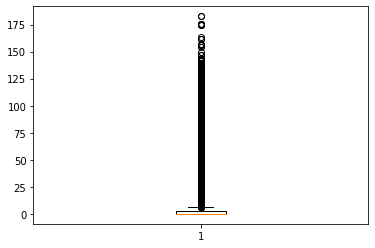

In [13]:
plt.boxplot(train_timeseries['PRECTOT'])
# It looks like there are a lot of outliers but that seem to be correct

/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

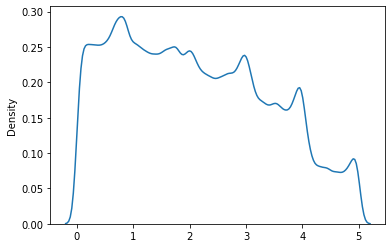

In [14]:
sns.kdeplot(pd.unique(train_timeseries['score']), bw = 0.05)

#### Analzse Validation and Test Timeseries

In [15]:
# Check for any missing value in all independent variables
print(val_timeseries.drop(columns = ['score']).isna().values.any())
print(test_timeseries.drop(columns = ['score']).isna().values.any())

False
False


In [16]:
val_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,2.268840e+06,323232.000000
mean,3.067038e+04,2.945218e+00,9.668289e+01,8.209934e+00,1.313680e+01,7.626656e+00,7.631953e+00,1.884739e+01,7.903998e+00,1.094340e+01,1.321793e+01,3.533742e+00,5.165298e+00,1.904352e+00,3.260947e+00,5.486969e+00,7.762958e+00,3.104674e+00,4.658297e+00,0.538601
std,1.497911e+04,6.883588e+00,5.443892e+00,4.905189e+00,1.093575e+01,1.049740e+01,1.035683e+01,1.151619e+01,1.064708e+01,3.951253e+00,1.113432e+01,1.845010e+00,2.607319e+00,1.342821e+00,1.927159e+00,2.310433e+00,2.851491e+00,2.115034e+00,2.155684e+00,0.916711
min,1.001000e+03,0.000000e+00,6.686000e+01,1.600000e-01,-3.329000e+01,-3.701000e+01,-3.358000e+01,-2.859000e+01,-3.815000e+01,2.000000e-02,-3.548000e+01,3.700000e-01,6.000000e-01,0.000000e+00,2.200000e-01,4.600000e-01,8.700000e-01,0.000000e+00,3.000000e-01,0.000000
25%,1.904450e+04,0.000000e+00,9.588000e+01,3.920000e+00,4.670000e+00,-4.400000e-01,-4.800000e-01,1.035000e+01,-4.400000e-01,8.140000e+00,4.540000e+00,2.120000e+00,3.110000e+00,9.400000e-01,1.810000e+00,3.770000e+00,5.640000e+00,1.420000e+00,3.110000e+00,0.000000
50%,2.921200e+04,1.900000e-01,9.832000e+01,7.260000e+00,1.458000e+01,8.510000e+00,8.420000e+00,2.081000e+01,8.670000e+00,1.090000e+01,1.461000e+01,3.140000e+00,4.670000e+00,1.640000e+00,2.810000e+00,5.120000e+00,7.300000e+00,2.760000e+00,4.220000e+00,0.000000
75%,4.600750e+04,2.500000e+00,9.998000e+01,1.218000e+01,2.251000e+01,1.671000e+01,1.665000e+01,2.824000e+01,1.701000e+01,1.364000e+01,2.269000e+01,4.560000e+00,6.710000e+00,2.560000e+00,4.250000e+00,6.830000e+00,9.420000e+00,4.390000e+00,5.760000e+00,1.000000
max,5.604300e+04,2.433200e+02,1.040600e+02,2.198000e+01,4.062000e+01,2.684000e+01,2.684000e+01,5.003000e+01,3.304000e+01,3.319000e+01,4.325000e+01,2.494000e+01,3.176000e+01,1.629000e+01,2.319000e+01,2.952000e+01,3.738000e+01,2.085000e+01,2.890000e+01,5.000000


/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

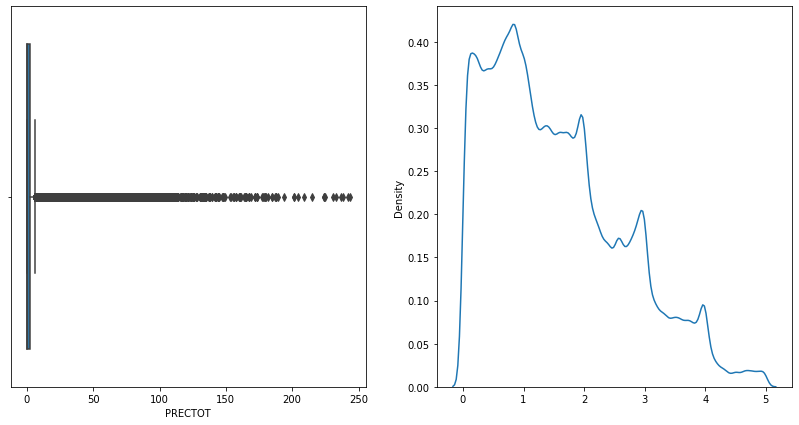

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
sns.boxplot(val_timeseries['PRECTOT'], orient = "v", ax = ax1)
sns.kdeplot(pd.unique(val_timeseries['score']), bw = 0.05, ax = ax2)

In [18]:
test_timeseries.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,2.271948e+06,326340.000000
mean,3.067038e+04,2.938845e+00,9.666175e+01,8.223259e+00,1.294575e+01,7.782536e+00,7.793077e+00,1.861224e+01,7.737146e+00,1.087509e+01,1.298156e+01,3.528208e+00,5.177723e+00,1.880345e+00,3.297381e+00,5.486035e+00,7.804205e+00,3.060228e+00,4.743982e+00,0.413486
std,1.497911e+04,6.719112e+00,5.443289e+00,4.925266e+00,1.085940e+01,1.033316e+01,1.010450e+01,1.140387e+01,1.063210e+01,3.850620e+00,1.106347e+01,1.834560e+00,2.618564e+00,1.310424e+00,1.971088e+00,2.291324e+00,2.869980e+00,2.071117e+00,2.202233e+00,0.838403
min,1.001000e+03,0.000000e+00,6.675000e+01,1.000000e-01,-3.857000e+01,-4.154000e+01,-3.859000e+01,-3.133000e+01,-4.546000e+01,1.200000e-01,-4.123000e+01,2.600000e-01,6.000000e-01,0.000000e+00,2.300000e-01,5.200000e-01,1.040000e+00,0.000000e+00,4.500000e-01,0.000000
25%,1.904450e+04,0.000000e+00,9.586000e+01,3.960000e+00,4.530000e+00,-1.600000e-01,-1.100000e-01,1.018000e+01,-5.000000e-01,8.140000e+00,4.410000e+00,2.120000e+00,3.110000e+00,9.400000e-01,1.820000e+00,3.790000e+00,5.670000e+00,1.410000e+00,3.160000e+00,0.000000
50%,2.921200e+04,2.100000e-01,9.830000e+01,7.060000e+00,1.389000e+01,8.250000e+00,8.090000e+00,2.014000e+01,8.080000e+00,1.078000e+01,1.388000e+01,3.140000e+00,4.680000e+00,1.620000e+00,2.820000e+00,5.100000e+00,7.310000e+00,2.720000e+00,4.300000e+00,0.000000
75%,4.600750e+04,2.540000e+00,9.996000e+01,1.222000e+01,2.223000e+01,1.685000e+01,1.671000e+01,2.787000e+01,1.680000e+01,1.353000e+01,2.236000e+01,4.540000e+00,6.710000e+00,2.530000e+00,4.300000e+00,6.820000e+00,9.450000e+00,4.320000e+00,5.860000e+00,0.406525
max,5.604300e+04,2.493400e+02,1.038800e+02,2.252000e+01,4.033000e+01,2.705000e+01,2.700000e+01,4.830000e+01,3.232000e+01,2.965000e+01,4.347000e+01,1.748000e+01,2.497000e+01,1.651000e+01,2.207000e+01,2.058000e+01,2.993000e+01,1.922000e+01,2.634000e+01,5.000000


/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/Pierrecounathe/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

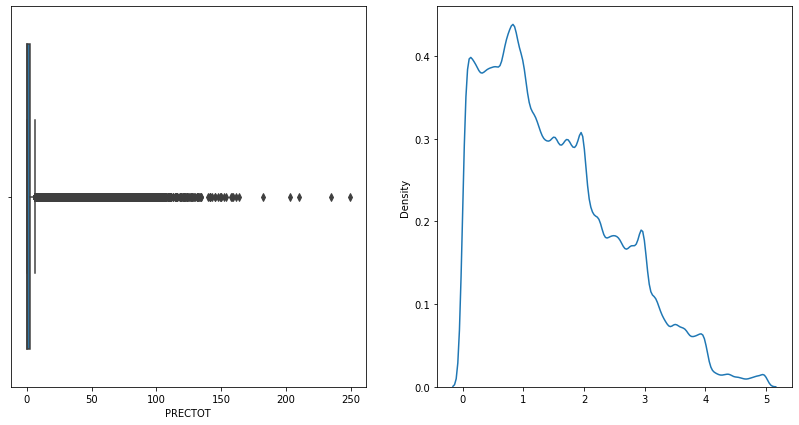

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))
sns.boxplot(test_timeseries['PRECTOT'], orient = "v", ax = ax1)
sns.kdeplot(pd.unique(test_timeseries['score']), bw = 0.05, ax = ax2)

#### Interpolate Drought score for Train, Validation and Test Timeseries

We plot below:
- True values of score on `fips` 1001 and on the first 1000 data points
- Linear interpolation of score on `fips` 1001 and on the first 1000 data points
- Polynomial (order 2) interpolation of score on `fips` 1001 and on the first 1000 data points

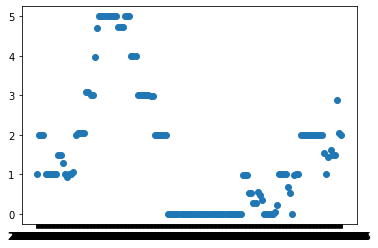

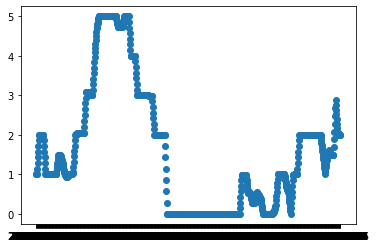

In [20]:
plt.scatter(train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['date'], train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score'])
plt.figure()
plt.scatter(train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['date'].interpolate(method = "linear", limit_direction = "both")
        , train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score'].interpolate(method = "linear", limit_direction = "both"))

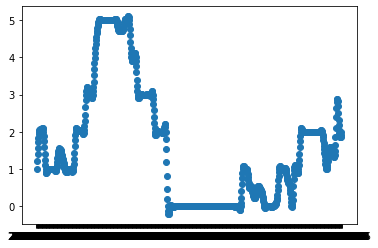

In [21]:
plt.scatter(train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['date']
        , train_timeseries[train_timeseries['fips'] == 1001].iloc[:1000]['score'].interpolate(method = "polynomial", order = 2, limit_direction = "both"))

Given the temporal distribution of the `score` feature, the linear interpolation seems right as it does not produce any aberrant value of `score`.

In [22]:
# Perform the score interpolation for the three datasets
train_timeseries['score'] = (train_timeseries[['fips', 'score']].groupby(['fips']).apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']
val_timeseries['score'] = (val_timeseries[['fips', 'score']].groupby('fips').apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']
test_timeseries['score'] = (test_timeseries[['fips', 'score']].groupby('fips').apply(lambda group: group.interpolate(method = "linear", limit_direction = "both")))['score']

Check the total number of `fips` divisions.

In [23]:
len(pd.unique(pd.concat((train_timeseries['fips'], val_timeseries['fips'], test_timeseries['fips']))))

3108

Check the distribution of our target variable `score`

(array([6549314., 1220428.,  739568.,  457054.,  269184.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

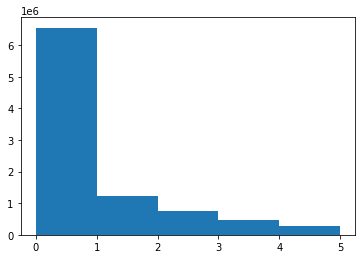

In [24]:
plt.hist(pd.concat((train_timeseries['score'], val_timeseries['score'], test_timeseries['score'])), bins = 5)

#### Analyze Soil Data

In [25]:
print(soil_data.shape)
print(len(pd.unique(soil_data['fips'])))
# Look for any missing value
print(soil_data.isna().values.any())
soil_data.head()

(3109, 32)
3109
False


,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


Quick description of the data

In [26]:
display(soil_data.iloc[:, :16].describe())
display(soil_data.iloc[:, 16:].describe())

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,30678.538437,38.280052,-91.659790,427.624638,0.054973,0.29775,0.319991,0.155878,0.053409,0.065323,0.022223,0.009267,0.143749,0.168888,0.148392,0.165061
std,14986.018730,4.838634,11.485291,500.158880,0.089873,0.21595,0.167727,0.128400,0.073107,0.125526,0.064127,0.044933,0.078237,0.084105,0.082111,0.087843
min,1001.000000,25.601043,-124.211407,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19045.000000,34.686818,-98.046842,132.000000,0.008300,0.10510,0.185800,0.040800,0.000500,0.000000,0.000000,0.000000,0.086200,0.109200,0.086300,0.101500
50%,29213.000000,38.328061,-90.181170,272.000000,0.028300,0.27100,0.347100,0.127500,0.012200,0.000700,0.000000,0.000000,0.144200,0.174000,0.148300,0.165500
75%,46009.000000,41.703590,-83.373303,483.000000,0.068500,0.47750,0.459300,0.255200,0.090300,0.054100,0.001200,0.000000,0.195600,0.227600,0.206600,0.223100
max,56045.000000,48.842653,-67.609354,3561.000000,0.974000,0.75990,0.696900,0.571700,0.330000,0.606800,0.476500,0.628800,0.478400,0.738500,0.511200,0.657800


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000
mean,0.352723,2.850511,1.801451,2.670026,19.812154,39.296586,28.494804,3.504682,31.999486,1.830492,1.553554,1.282084,1.35735,1.146993,1.135092,1.284979
std,0.272182,13.159247,7.971805,9.770693,25.447435,34.365530,31.839502,10.290893,33.099657,1.192219,1.021382,1.002508,1.03011,0.922308,0.914502,1.017465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.115600,0.000000,0.000000,0.104800,4.360057,4.552230,0.143526,0.045909,1.602227,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
50%,0.305900,0.000000,0.000000,0.488500,8.839095,30.573359,14.043937,0.276606,18.811279,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
75%,0.555200,0.000000,0.000000,1.115100,23.720787,74.532990,51.737080,1.370315,60.637421,3.000000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,1.000000,100.000000,99.982918,99.998764,99.998596,91.044609,97.029572,99.956841,99.956841,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000


Columns are:
- `fips`, `lat`,`lon`, `elevation`
- `slope` 1 to 8 : percentage of the fips that falls in each slope % (between 0 and 1, sums to 1 for most of the fips)
- `aspect` N, S, E, W, Unkown: percentage of the fips that falls in each category (between 0 and 100, sums to 100 for most of the fips)
- `WAT_LAND`: mapped water bodies
- `NVG_LAND`: sparsely vegetated land
- `URB_LAND`: built up land (resdential and infrastructure)
- `GRS_LAND`: gras/scrub/woodland
- `FOR_LAND`: forest
- `CULTRF_LAND`: rain-fed cultivated land
- `CULTIR_LAND`: irrigated cultivated land
- `CULT_LAND`: total cultivated land (this is the sum of both previous variables)
- `SQ` 1 to 7: each column describes a specific aspect of the soil quality (from 1 to 7: nutrient availability, nutrient retention capacity, rooting conditions, oxygen avilability to roots, excess salts, toxicity, workability). And each one of these attributes is classified (from 1 to 7: No or slight constraints, moderate constraints, severe constraints, very severe constraints, mainly non soil, permafrost area, water bodies)
    

##### Slope and Aspect exploration

Check which are the `fips` for which  the `slope` percentages do not sum to 1, and for which  the `aspect` percentages do not sum to 1 or sum to 0.

In [27]:
print(sum(abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1)) < 0.001))

print(sum(abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1)) < 0.001))

121
35
121
35


(array([3.700e+01, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 4.000e+00,
        4.000e+00, 2.993e+03]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

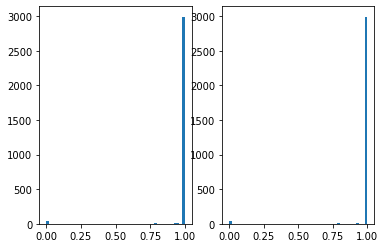

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1), bins = 50)
ax2.hist(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1), bins = 50)

In [29]:
display(soil_data[abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,38.921744,-83.525686,25.652893,0.051193,0.202029,0.141972,0.045038,0.008860,0.005240,0.001136,0.000178,0.043864,0.057326,0.047093,0.054142
std,5.785910,11.314912,55.582628,0.076635,0.198374,0.146175,0.069209,0.022394,0.028682,0.010827,0.001873,0.054074,0.066752,0.054039,0.060077
min,26.552134,-123.100616,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.606269,-87.481575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.563855,-81.892250,4.000000,0.025900,0.176700,0.093600,0.010700,0.000100,0.000000,0.000000,0.000000,0.024100,0.036200,0.030000,0.032700
75%,43.458758,-76.162488,16.000000,0.072000,0.339500,0.254100,0.065100,0.003800,0.000500,0.000000,0.000000,0.074500,0.098200,0.077600,0.095200
max,48.508862,-69.038515,292.000000,0.468100,0.645400,0.496200,0.302400,0.140900,0.299200,0.118900,0.020600,0.342400,0.297800,0.252700,0.232000


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.253222,41.135483,0.765421,5.489403,3.202746,13.217629,3.645588,0.372913,4.018501,3.545455,3.479339,3.239669,3.421488,3.214876,3.214876,3.272727
std,0.255955,43.401379,6.955712,18.382208,7.682592,23.140544,8.773417,1.194338,9.249541,3.093003,3.117422,3.224967,3.148418,3.235755,3.235755,3.227486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.213000,19.725800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035098,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,0.404800,100.000000,0.000000,0.605300,3.850647,18.251228,1.189633,0.132908,2.694110,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.927300,100.000000,76.000000,97.305885,55.409653,90.462379,48.940243,10.822440,49.288582,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [30]:
display(soil_data[abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,38.921744,-83.525686,25.652893,0.051193,0.202029,0.141972,0.045038,0.008860,0.005240,0.001136,0.000178,0.043864,0.057326,0.047093,0.054142
std,5.785910,11.314912,55.582628,0.076635,0.198374,0.146175,0.069209,0.022394,0.028682,0.010827,0.001873,0.054074,0.066752,0.054039,0.060077
min,26.552134,-123.100616,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.606269,-87.481575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.563855,-81.892250,4.000000,0.025900,0.176700,0.093600,0.010700,0.000100,0.000000,0.000000,0.000000,0.024100,0.036200,0.030000,0.032700
75%,43.458758,-76.162488,16.000000,0.072000,0.339500,0.254100,0.065100,0.003800,0.000500,0.000000,0.000000,0.074500,0.098200,0.077600,0.095200
max,48.508862,-69.038515,292.000000,0.468100,0.645400,0.496200,0.302400,0.140900,0.299200,0.118900,0.020600,0.342400,0.297800,0.252700,0.232000


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,0.253222,41.135483,0.765421,5.489403,3.202746,13.217629,3.645588,0.372913,4.018501,3.545455,3.479339,3.239669,3.421488,3.214876,3.214876,3.272727
std,0.255955,43.401379,6.955712,18.382208,7.682592,23.140544,8.773417,1.194338,9.249541,3.093003,3.117422,3.224967,3.148418,3.235755,3.235755,3.227486
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.213000,19.725800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035098,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,0.404800,100.000000,0.000000,0.605300,3.850647,18.251228,1.189633,0.132908,2.694110,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.927300,100.000000,76.000000,97.305885,55.409653,90.462379,48.940243,10.822440,49.288582,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In most of the cases, these fips have a high proportion of `WAT_LAND`.

##### Land Type exploration

- Check the distribution of the sum of every land type
- Check for which fips ths sum does not add up to 100
- Check that `CULTRF_LAND` and `CULTIR_LAND` sum to `CULT_LAND`

(array([4.50e+01, 2.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

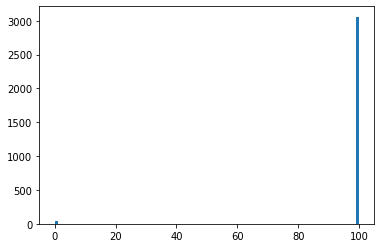

In [31]:
# Distribution of the sum of land types
plt.hist(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1), bins = 101)

In [32]:
# For which fips the sum of land types does not add up to 100
display(soil_data[abs(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1) - 100) > 2].iloc[:, 1:16].describe())
display(soil_data[abs(soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1) - 100) > 2].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,36.508326,-81.681640,11.183673,0.068982,0.286869,0.184473,0.051496,0.009924,0.008959,0.002618,0.000429,0.049955,0.071851,0.062163,0.073931
std,5.052494,13.947290,22.254844,0.064609,0.201433,0.130801,0.061849,0.021027,0.043237,0.016989,0.002942,0.040824,0.057874,0.050275,0.060696
min,28.298276,-123.100616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.358147,-84.799174,2.000000,0.017400,0.109200,0.052500,0.005900,0.000000,0.000000,0.000000,0.000000,0.015700,0.021700,0.017000,0.024000
50%,36.265276,-76.404269,5.000000,0.055800,0.263800,0.176000,0.035800,0.001200,0.000000,0.000000,0.000000,0.041100,0.062000,0.069300,0.067100
75%,40.731384,-73.837929,11.000000,0.098000,0.465700,0.281500,0.076500,0.006700,0.001400,0.000000,0.000000,0.074700,0.103000,0.086900,0.106500
max,48.508862,-68.370703,150.000000,0.314700,0.706900,0.464500,0.255300,0.089800,0.299200,0.118900,0.020600,0.183200,0.233000,0.252700,0.218500


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.000000,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.0
mean,0.355851,0.0,0.0,0.0,0.0,0.0,0.0,0.398610,0.398610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.253100,0.0,0.0,0.0,0.0,0.0,0.0,1.493837,1.493837,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.151400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.302100,0.0,0.0,0.0,0.0,0.0,0.0,0.001138,0.001138,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.557800,0.0,0.0,0.0,0.0,0.0,0.0,0.101333,0.101333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.863200,0.0,0.0,0.0,0.0,0.0,0.0,9.967068,9.967068,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Check that the columns CULTRF_LAND and CULTIR_LAND sum to CULT_LAND
sum(abs(soil_data['CULTRF_LAND'] + soil_data['CULTIR_LAND'] - soil_data['CULT_LAND']) > 0.001)

0

- `fips` for which the land types sum to 0 are `fips`  with bad data (SQ1 to 7 is null; sum of slopes mean does not sum to 1 while it should; land types are almost all 0, and do not sum to 100)
- `CULTRF_LAND` and `CULTIR_LAND` indeed sum to `CULT_LAND`. We thus drop this last column that is not usefull.

In [34]:
soil_data.drop(columns = ['CULT_LAND'], inplace = True)

##### Soil Quality exploration

In [35]:
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1].describe().iloc[:, 1:16])
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1].describe().iloc[:, 16:32])

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,36.508326,-81.681640,11.183673,0.068982,0.286869,0.184473,0.051496,0.009924,0.008959,0.002618,0.000429,0.049955,0.071851,0.062163,0.073931
std,5.052494,13.947290,22.254844,0.064609,0.201433,0.130801,0.061849,0.021027,0.043237,0.016989,0.002942,0.040824,0.057874,0.050275,0.060696
min,28.298276,-123.100616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.358147,-84.799174,2.000000,0.017400,0.109200,0.052500,0.005900,0.000000,0.000000,0.000000,0.000000,0.015700,0.021700,0.017000,0.024000
50%,36.265276,-76.404269,5.000000,0.055800,0.263800,0.176000,0.035800,0.001200,0.000000,0.000000,0.000000,0.041100,0.062000,0.069300,0.067100
75%,40.731384,-73.837929,11.000000,0.098000,0.465700,0.281500,0.076500,0.006700,0.001400,0.000000,0.000000,0.074700,0.103000,0.086900,0.106500
max,48.508862,-68.370703,150.000000,0.314700,0.706900,0.464500,0.255300,0.089800,0.299200,0.118900,0.020600,0.183200,0.233000,0.252700,0.218500


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.0
mean,0.355851,0.0,0.0,0.0,0.0,0.0,0.0,0.398610,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.253100,0.0,0.0,0.0,0.0,0.0,0.0,1.493837,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.151400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.302100,0.0,0.0,0.0,0.0,0.0,0.0,0.001138,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.557800,0.0,0.0,0.0,0.0,0.0,0.0,0.101333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.863200,0.0,0.0,0.0,0.0,0.0,0.0,9.967068,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- `fips` with SQ that sums to less than 1 are exactly the same as those spotted with problems in land types

<AxesSubplot:>

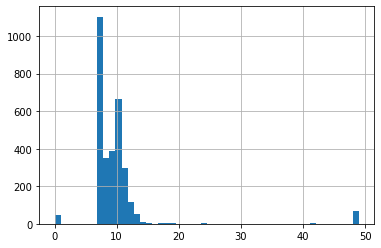

In [36]:
(soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']]).sum(axis = 1).hist(bins = 50)

In [37]:
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) > 20].iloc[:, 1:16].describe())
display(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) > 20].iloc[:, 16:32].describe())

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,40.727727,-86.791137,230.635135,0.033449,0.149876,0.149766,0.066557,0.015853,0.019030,0.012958,0.020230,0.058699,0.080145,0.076596,0.068954
std,4.548871,11.162826,706.935923,0.067744,0.182096,0.184443,0.099399,0.034335,0.062745,0.049702,0.100744,0.076229,0.094237,0.102249,0.082775
min,28.445366,-122.746757,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.723142,-87.649611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.657199,-86.125463,5.000000,0.005450,0.043050,0.041900,0.006200,0.000150,0.000000,0.000000,0.000000,0.019800,0.025500,0.015300,0.017100
75%,44.088048,-77.391414,166.750000,0.034900,0.277725,0.265625,0.104400,0.019900,0.001150,0.000000,0.000000,0.104075,0.160750,0.132525,0.139125
max,48.158436,-73.300758,3561.000000,0.343100,0.644400,0.529100,0.382000,0.188000,0.326900,0.261200,0.628800,0.287200,0.301100,0.412800,0.292900


,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.183324,66.643162,0.682777,3.869399,4.515802,17.958345,5.162673,1.167842,6.878378,6.878378,6.851351,6.878378,6.851351,6.851351,6.851351
std,0.240226,37.651384,3.109817,13.177896,10.995602,26.265390,11.029489,8.009889,0.522185,0.522185,0.676057,0.522185,0.676057,0.676057,0.676057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000
25%,0.000000,37.821974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
50%,0.048900,79.482300,0.000000,0.000000,0.421900,1.819059,0.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
75%,0.308350,100.000000,0.000000,0.593003,4.731696,30.900002,4.562543,0.144397,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
max,0.987500,100.000000,19.999998,94.704834,82.445999,91.044609,47.477272,68.696198,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [38]:
soil_data[soil_data['WAT_LAND'] > 90].describe()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.0,35.0,35.0,35.0,35.0,35.0,35.0
mean,34817.857143,43.903468,-85.043654,26.057143,0.008211,0.034766,0.020943,0.008914,0.001980,0.000589,...,0.152267,0.056294,0.003948,7.0,7.0,7.0,7.0,7.0,7.0,7.0
std,12685.875270,2.225098,3.644812,65.031188,0.034888,0.117357,0.058623,0.038792,0.010656,0.003379,...,0.823373,0.189538,0.022457,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,17097.000000,37.425348,-90.290190,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
25%,26076.000000,42.848211,-87.364252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
50%,26139.000000,43.996636,-86.602967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
75%,45100.000000,45.106995,-83.116733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.0,7.0,7.0,7.0,7.0,7.0,7.0
max,55117.000000,47.681981,-76.047433,208.000000,0.202000,0.609300,0.227700,0.225100,0.063000,0.020000,...,4.872879,0.809390,0.132908,7.0,7.0,7.0,7.0,7.0,7.0,7.0


- `fips` with all SQ set to 7 are mainly `WAT_LAND`

Given the observations on land types and on SQ, we drop `fips` for which SQ are all 0 and land types are almost all 0.

- Those `fips` were also causing problems in the `slope` and `aspect` columns.
- We thus solve our problem in land types

In [39]:
restr_soil_data = soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) >= 1]

In [40]:
print(sum(abs(restr_soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(restr_soil_data[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']].sum(axis = 1)) < 0.001))

print(sum(abs(restr_soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1) - 1) > 0.001))
print(sum(abs(restr_soil_data[['aspectN', 'aspectS', 'aspectE', 'aspectW', 'aspectUnknown']].sum(axis = 1)) < 0.001))

82
31
82
31


(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   1.,
          3.,   0.,   2.,  16.,   6.,  13.,  11.,  16.,  16.,  19.,  10.,
         17.,   7.,  16.,  14.,  12.,  18.,  16.,  15.,  16.,  25.,  18.,
         25.,  27.,  25.,  32.,  37.,  42.,  36.,  55.,  39.,  63.,  52.,
         53., 139., 135., 154., 191., 342., 140., 165., 141., 120.,  58.,
         38.,  47.,  63.,  55.,  37.,  23.,  22.,  40.,  26.,  31.,  30.,
         36.,  10.,  18.,  15.,  13.,  12.,  17.,  16.,  16.,  17.,  14.,
         19.,  15.,   8.,  14.,  11.,  13.,  11.,   8.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.]),
 array([ 99.99999461,  99.99999472,  99.99999483,  99.99999494,
         99.99999505,  99.99999515,  99.99999526,  99.99999537,
         99.99999548,  99.99999559,  99.9999957 ,  99.99999581,
         99.99999592,  99.99999603,  99.99999614,  99.99999624,
         99.99999635,  99.99999646,  99.99999657,  99.99

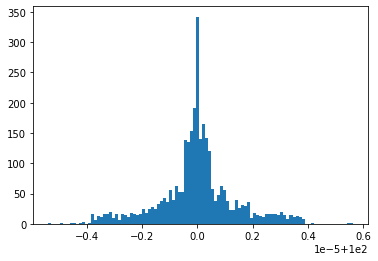

In [41]:
# Distribution of the sum of land types
plt.hist(restr_soil_data[['WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND', 'CULTIR_LAND']].sum(axis = 1), bins = 101)

We look for `fips` codes that are problematic in the soil data perspective.

In [50]:
pd.unique(soil_data[soil_data[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']].sum(axis = 1) < 1]['fips']).tolist()

[6075,
 6083,
 6087,
 9009,
 12009,
 12037,
 13127,
 13191,
 22023,
 22045,
 22051,
 22075,
 22087,
 22099,
 23009,
 23013,
 23015,
 24047,
 25007,
 25009,
 25019,
 25025,
 28047,
 34009,
 34017,
 36047,
 36059,
 36081,
 36085,
 36103,
 37013,
 37019,
 37029,
 37031,
 37055,
 37095,
 37129,
 37137,
 37139,
 37143,
 44005,
 44009,
 45013,
 45019,
 45043,
 48167,
 51131,
 51810,
 53055]

# Merge time series and soil data

In [47]:
train_data = pd.merge(train_timeseries, soil_data, on = 'fips', how = 'left')
train_data.head()

val_data = pd.merge(val_timeseries, soil_data, on = 'fips', how = 'left')
val_data.head()

test_data = pd.merge(test_timeseries, soil_data, on = 'fips', how = 'left')
test_data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2019-01-01,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,...,10.714703,56.293411,1.014811,1,1,1,1,1,1,2
1,1001,2019-01-02,4.94,100.48,8.65,13.05,11.83,11.74,17.76,9.54,...,10.714703,56.293411,1.014811,1,1,1,1,1,1,2
2,1001,2019-01-03,20.74,100.03,8.59,12.12,11.67,11.67,13.74,10.44,...,10.714703,56.293411,1.014811,1,1,1,1,1,1,2
3,1001,2019-01-04,16.17,99.47,7.93,11.80,10.38,9.59,18.19,5.44,...,10.714703,56.293411,1.014811,1,1,1,1,1,1,2
4,1001,2019-01-05,0.01,100.39,5.32,7.91,4.73,4.71,14.37,3.68,...,10.714703,56.293411,1.014811,1,1,1,1,1,1,2


In [53]:
print(val_timeseries.shape)
print(val_data.shape)

(2268840, 21)
(2268840, 51)


In [58]:
val_data[~val_data['fips'].isin([1001, 1003])]

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,FOR_LAND,CULTRF_LAND,CULTIR_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
1460,1005,2017-01-01,66.35,100.42,11.53,16.16,15.86,15.86,20.59,10.05,...,22.952839,72.578804,1.828159,3,2,1,1,1,1,1
1461,1005,2017-01-02,47.72,100.47,13.10,18.48,18.25,18.25,21.12,17.16,...,22.952839,72.578804,1.828159,3,2,1,1,1,1,1
1462,1005,2017-01-03,7.52,99.91,10.81,16.68,15.00,15.00,19.55,11.49,...,22.952839,72.578804,1.828159,3,2,1,1,1,1,1
1463,1005,2017-01-04,0.07,100.05,6.83,10.73,8.10,8.11,15.22,4.96,...,22.952839,72.578804,1.828159,3,2,1,1,1,1,1
1464,1005,2017-01-05,0.00,100.06,5.51,8.10,4.95,4.96,14.99,1.89,...,22.952839,72.578804,1.828159,3,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268835,56043,2018-12-27,0.14,82.71,1.54,-9.57,-14.20,-13.09,-6.23,-12.06,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268836,56043,2018-12-28,0.02,83.14,1.32,-11.25,-15.98,-14.57,-7.03,-14.33,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268837,56043,2018-12-29,0.34,82.78,1.75,-7.17,-12.62,-12.17,0.64,-14.85,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
2268838,56043,2018-12-30,3.17,81.97,2.72,-2.84,-7.14,-6.95,2.14,-8.49,...,0.000000,0.000000,0.000000,1,1,1,1,1,1,1
